# Probability direction generator

### Setup

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

In [1]:
from dipy.data import read_stanford_labels
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel
from dipy.tracking import utils
from dipy.tracking.local import (ThresholdTissueClassifier, LocalTracking)

hardi_img, gtab, labels_img = read_stanford_labels()
data = hardi_img.get_data()
labels = labels_img.get_data()
affine = hardi_img.get_affine()

seed_mask = labels == 2
white_matter = (labels == 1) | (labels == 2)
seeds = utils.seeds_from_mask(seed_mask, density=1, affine=affine)

csd_model = ConstrainedSphericalDeconvModel(gtab, None, sh_order=6)
csd_fit = csd_model.fit(data, mask=white_matter)

Dataset is already in place. If you want to fetch it again please first remove the folder /root/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /root/.dipy/stanford_hardi 
Files successfully downloaded to /root/.dipy/stanford_hardi


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0


In [2]:
from dipy.reconst.shm import CsaOdfModel

csa_model = CsaOdfModel(gtab, sh_order=6)
gfa = csa_model.fit(data, mask=white_matter).gfa
classifier = ThresholdTissueClassifier(gfa, .25)

## Simple Probability Model

In [3]:
from dipy.direction import ProbabilisticDirectionGetter
from dipy.data import small_sphere
from dipy.io.trackvis import save_trk

fod = csd_fit.odf(small_sphere)
pmf = fod.clip(min=0)
prob_dg = ProbabilisticDirectionGetter.from_pmf(pmf, max_angle=30.,
                                                sphere=small_sphere)
streamlines = LocalTracking(prob_dg, classifier, seeds, affine, step_size=.5)
save_trk("probabilistic_small_sphere.trk", streamlines, affine, labels.shape)

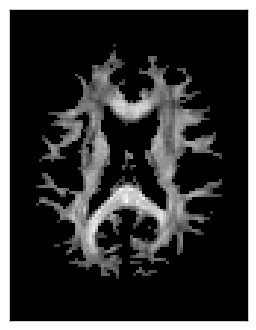

In [9]:
mask_fa = gfa.copy()
mask_fa[mask_fa < 0.2] = 0
plt.xticks([])
plt.yticks([])
plt.imshow(mask_fa[:, :, data.shape[2] / 2].T, cmap='gray', origin='lower',
           interpolation='nearest')

In [11]:
all_streamlines_threshold_classifier = LocalTracking(prob_dg,
                                                     classifier,
                                                     seeds,
                                                     affine,
                                                     step_size=.5,
                                                     return_all=True)
streamlines = [sl for sl in all_streamlines_threshold_classifier]

In [10]:
from dipy.viz import fvtk
from dipy.viz.colormap import line_colors

ren = fvtk.ren()

fvtk.clear(ren)
fvtk.add(ren, fvtk.line(streamlines, line_colors(streamlines)))
fvtk.show(ren)

![](https://github.com/NeuroDataDesign/seelviz/blob/gh-pages/albert/prob/probability1.png?raw=true)

The above model is the simplest probabilistic model that Dipy offers. It estimates the distribution of fiber bundles within each individual voxel. This fiber orientation distribution (FOD) is used to genereate a discrete sphere. This distribution is then used to sample possible directions.

## Reduced RAM Implementation

In [12]:
from dipy.data import default_sphere

prob_dg = ProbabilisticDirectionGetter.from_shcoeff(csd_fit.shm_coeff,
                                                    max_angle=30.,
                                                    sphere=default_sphere)
streamlines = LocalTracking(prob_dg, classifier, seeds, affine, step_size=.5)

save_trk("probabilistic_shm_coeff.trk", streamlines, affine, labels.shape)

A spherical harmonic representation of the FOD can be used to reduce the amount of RAM necessary for computation. A larger sphere thus can be used to increase accuracy and probabilistic rigor.

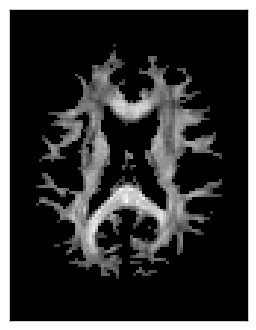

In [13]:
mask_fa = gfa.copy()
mask_fa[mask_fa < 0.2] = 0
plt.xticks([])
plt.yticks([])
plt.imshow(mask_fa[:, :, data.shape[2] / 2].T, cmap='gray', origin='lower',
           interpolation='nearest')

In [14]:
all_streamlines_threshold_classifier = LocalTracking(prob_dg,
                                                     classifier,
                                                     seeds,
                                                     affine,
                                                     step_size=.5,
                                                     return_all=True)
streamlines = [sl for sl in all_streamlines_threshold_classifier]

In [ ]:
from dipy.viz import fvtk
from dipy.viz.colormap import line_colors

ren = fvtk.ren()

fvtk.clear(ren)
fvtk.add(ren, fvtk.line(streamlines, line_colors(streamlines)))
fvtk.show(ren)

![](https://github.com/NeuroDataDesign/seelviz/blob/gh-pages/albert/prob/probability2.png?raw=true)

## Peaks from Model Implementation

In [15]:
from dipy.direction import peaks_from_model

peaks = peaks_from_model(csd_model, data, default_sphere, .5, 25,
                         mask=white_matter, return_sh=True, parallel=True)
fod_coeff = peaks.shm_coeff
prob_dg = ProbabilisticDirectionGetter.from_shcoeff(fod_coeff, max_angle=30.,
                                                    sphere=default_sphere)
streamlines = LocalTracking(prob_dg, classifier, seeds, affine, step_size=.5)
save_trk("probabilistic_peaks_from_model.trk", streamlines, affine,
         labels.shape)

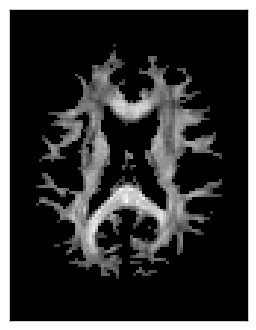

In [16]:
mask_fa = gfa.copy()
mask_fa[mask_fa < 0.2] = 0
plt.xticks([])
plt.yticks([])
plt.imshow(mask_fa[:, :, data.shape[2] / 2].T, cmap='gray', origin='lower',
           interpolation='nearest')

A dataset needs to have a shm_coeff attribute in order to use spherical probabilistic representation. In this case it is best to use the spherical harmonic basis to fit the original ODF.

In [17]:
all_streamlines_threshold_classifier = LocalTracking(prob_dg,
                                                     classifier,
                                                     seeds,
                                                     affine,
                                                     step_size=.5,
                                                     return_all=True)
streamlines = [sl for sl in all_streamlines_threshold_classifier]

In [ ]:
from dipy.viz import fvtk
from dipy.viz.colormap import line_colors

ren = fvtk.ren()

fvtk.clear(ren)
fvtk.add(ren, fvtk.line(streamlines, line_colors(streamlines)))
fvtk.show(ren)

![](https://github.com/NeuroDataDesign/seelviz/blob/gh-pages/albert/prob/probability3.png?raw=true)